# **Pre Classification Analysis** 

In [1]:
import sys
sys.path
sys.path.append('c:\\Users\\3leso\\Documents\\Elena\\Uni\\MasterThesis\\MasterThesis_final\\code\\preprocessing')

### Set file paths

In [2]:
file_comments = "../../../../data/reddit/AmericanPolitics_comments.zst"
file_submissions = "../../../../data/reddit/AmericanPolitics_submissions.zst"

subreddit_here = "AmericanPolitics"
subreddit = "AmericanPolitics"


output_path = f"output/{subreddit_here}_new_preprocessing_com_rep.csv"



In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain

import zstandard
import io

from sklearn.model_selection import train_test_split
from scipy import sparse
import random
from itertools import combinations
import collections
import multiprocessing
import copy
import time
#import gurobipy
#from gurobipy import *

pd.options.mode.chained_assignment = None

In [4]:
from preprocessing_functions import import_subreddit
from preprocessing_functions import filter_subreddit
from preprocessing_functions import aggregate_interactions_directed
from preprocessing_functions import get_counts_and_shares
from preprocessing_functions import find_max
from preprocessing_functions import build_undirected
from preprocessing_functions import get_submissions
from preprocessing_functions import get_comments_and_replies
from preprocessing_functions import assign_types
from preprocessing_functions import find_relevant_submissions
from preprocessing_functions import plot_submissions_comments
from preprocessing_functions import match_reply_comment_submission
from preprocessing_functions import preprocess_texts
from preprocessing_functions import import_merge_predicted_labels

***

## **Data Import**

In [5]:
# import data
data_comments = import_subreddit(file_comments)
data_submissions = import_subreddit(file_submissions)


In [6]:
# make df
df_comments = pd.DataFrame(data_comments)
df_submissions = pd.DataFrame(data_submissions)

In [7]:
# submissions
# filter relevant columns

submissions = get_submissions(df_submissions)

In [8]:
# comments
# select relevant columns only

df_comments_replies = get_comments_and_replies(df_comments)

In [9]:
# assign types and extract them to separate dfs
comments, replies = assign_types(df_comments_replies, submissions)

### Filter relevant submissions

* relevant = above subreddit-average number of comments
* relevant_comments: those with a parent, that is in relevant_submissions

***
**Flowchart of Dropouts**

In [12]:
relevant_submissions = pd.DataFrame(comments.groupby('parent_id')['id'].count()).reset_index().rename(columns={'parent_id' : 'submission_id', 'id' : 'count'})
print(relevant_submissions['count'].mean())
relevant_submissions
# get nr of submissions, for which I do have comments --> 29.304


1.8178405678405678


,submission_id,count
0,1001ldy,1
1,1001lpm,1
2,1001m29,1
3,1009shs,2
4,100lgjk,2
...,...,...
29299,zznnzg,2
29300,zznse9,1
29301,zztlcn,1
29302,zzz9k9,3


In [17]:
plt_data = pd.DataFrame(relevant_submissions['count'].value_counts()).rename(columns={'count' : 'class_count'}).reset_index().rename(columns={'count' : 'comment_count'}).sort_values(by = "comment_count").reset_index(drop=True)
plt_data

,comment_count,class_count
0,1,16611
1,2,7008
2,3,3046
3,4,1328
4,5,672
5,6,308
6,7,153
7,8,80
8,9,43
9,10,29


In [ ]:
bin_edges = np.arange(0, plt_data['comment_count'].max() + 1, 1)
plt.hist(relevant_submissions['count'], bins = bin_edges)
plt.xlabel("comment count")
plt.ylabel("#submissions")
plt.title("Nr of Comments per Submission")

Text(0, 0.5, 'Nr. of submissions')

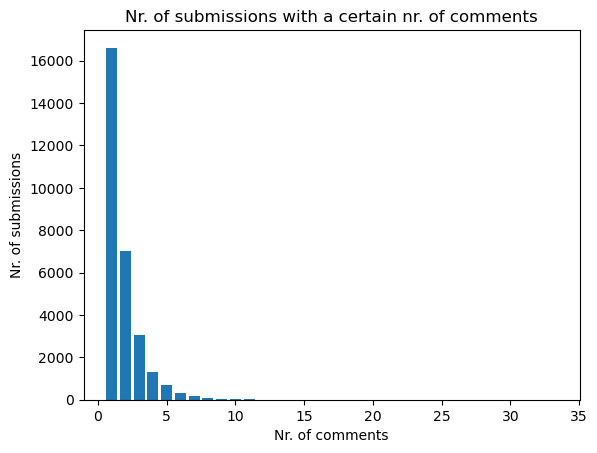

In [19]:
# excluding 248 comments

plt.bar(x = plt_data['comment_count'][:16], height = plt_data['class_count'][:16])
plt.title("Nr. of submissions with a certain nr. of comments")
plt.xlabel("Nr. of comments")
plt.ylabel("Nr. of submissions")

Text(0, 0.5, 'Nr. of submissions')

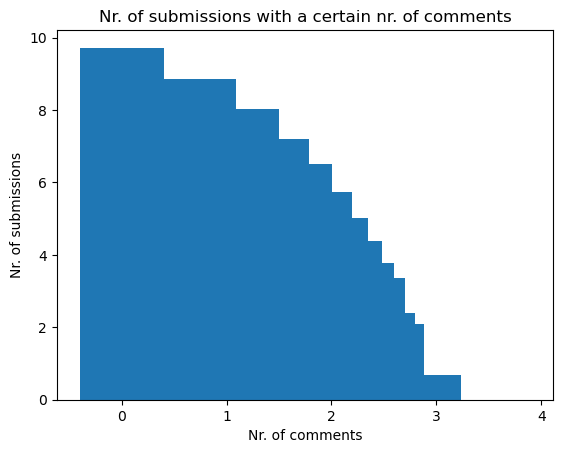

In [22]:
plt_data['log_comm_count'] = plt_data['comment_count'].apply(lambda x: np.log(x))
plt_data['log_class_count'] = plt_data['class_count'].apply(lambda x: np.log(x))
plt_data

plt.bar(x = plt_data['log_comm_count'][:16], height = plt_data['log_class_count'][:16])
plt.title("Nr. of submissions with a certain nr. of comments")
plt.xlabel("Nr. of comments")
plt.ylabel("Nr. of submissions")

In [24]:
plt_data

,comment_count,class_count,log_comm_count,log_class_count
0,1,16611,0.000000,9.717820
1,2,7008,0.693147,8.854808
2,3,3046,1.098612,8.021585
3,4,1328,1.386294,7.191429
4,5,672,1.609438,6.510258
5,6,308,1.791759,5.730100
6,7,153,1.945910,5.030438
7,8,80,2.079442,4.382027
8,9,43,2.197225,3.761200
9,10,29,2.302585,3.367296


Mean nr. of comments per submission 1.8178405678405678
Nr. of submission, that I have comments for 29304


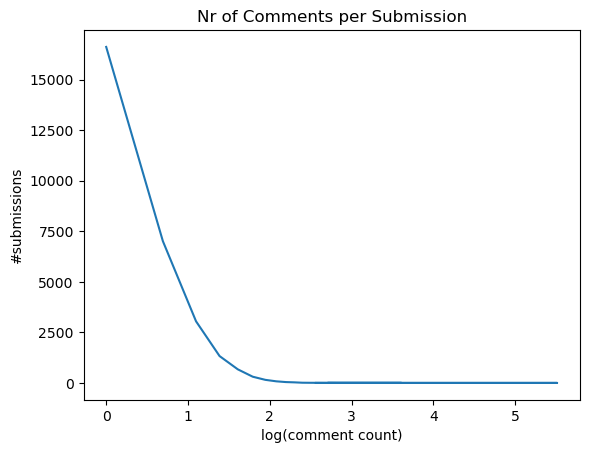

In [28]:
#plot_submissions_comments(df_comments = comments, df_submissions = submissions, submission_id_col = "parent_id", comment_id_col = "id", log_x = True, log_y = True)

plot_submissions_comments(df_comments = comments, df_submissions = submissions, submission_id_col = "parent_id", comment_id_col = "id", log_x = True, log_y = False)

#plot_submissions_comments(df_comments = comments, df_submissions = submissions, submission_id_col = "parent_id", comment_id_col = "id", log_x = False, log_y = True)

#plot_submissions_comments(df_comments = comments, df_submissions = submissions, submission_id_col = "parent_id", comment_id_col = "id", log_x = False, log_y = False)

In [29]:
df_submissions_filtered = submissions[submissions['id'].isin(relevant_submissions['submission_id'])].reset_index(drop=True)
df_submissions_filtered

# all of them, I can find in my submissions

,author,created_utc,id,num_comments,score,send_replies,stickied,subreddit,subreddit_id,title,name,likes,ups,category,selftext,type,date
0,BravoLima,1.212442e+09,6lsfk,2,0,True,False,AmericanPolitics,t5_2qied,Karl Rove: 9/11 Truther? (video),NaN,NaN,NaN,NaN,,submission,2008-06-02
1,[deleted],1.212775e+09,6mbh5,1,4,True,False,AmericanPolitics,t5_2qied,Aimee Allen's New Ron Paul Anthem Music Video ...,NaN,NaN,NaN,NaN,,submission,2008-06-06
2,BravoLima,1.212970e+09,6mjpb,1,0,True,False,AmericanPolitics,t5_2qied,Bush Crime Family Reich: Legislating Tyranny i...,NaN,NaN,NaN,NaN,,submission,2008-06-09
3,BravoLima,1.213030e+09,6mmwd,1,0,True,False,AmericanPolitics,t5_2qied,Bush Administration Not 'NeoCon' Enough for Li...,NaN,NaN,NaN,NaN,,submission,2008-06-09
4,BravoLima,1.213041e+09,6mnuv,1,4,True,False,AmericanPolitics,t5_2qied,'Ron Paul Republican' Candidate Terrorized (vi...,NaN,NaN,NaN,NaN,,submission,2008-06-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29299,shallah,1.703974e+09,18urago,7,17,False,False,AmericanPolitics,t5_2qied,Maine secretary of state who opted to keep Tru...,t3_18urago,NaN,17.0,None,,submission,2023-12-30
29300,simplywas,1.703987e+09,18uw47n,1,1,True,False,AmericanPolitics,t5_2qied,Brother Cornel West,t3_18uw47n,NaN,1.0,None,[removed],submission,2023-12-31
29301,machinade89,1.703994e+09,18uye95,3,8,False,False,AmericanPolitics,t5_2qied,Opinion | Biden’s 2024 chances are much strong...,t3_18uye95,NaN,8.0,None,,submission,2023-12-31
29302,machinade89,1.704038e+09,18vanb9,12,26,True,False,AmericanPolitics,t5_2qied,"Opinion | Yes, Trump should be removed from th...",t3_18vanb9,NaN,26.0,None,,submission,2023-12-31


In [30]:
df_submissions_filtered[~df_submissions_filtered['selftext'].isin(["", "[deleted]", "[removed]"])]

,author,created_utc,id,num_comments,score,send_replies,stickied,subreddit,subreddit_id,title,name,likes,ups,category,selftext,type,date
549,RedCoJones,1.246374e+09,8wzjg,5,5,True,False,AmericanPolitics,t5_2qied,Dear Reddit: Is it now safe to say that Mr. Ob...,NaN,NaN,NaN,NaN,1) Continues to detain enemy combatants withou...,submission,2009-06-30
550,tdsinfo,1.246381e+09,8x127,1,1,True,False,AmericanPolitics,t5_2qied,"EPA ""Suppressed Dissent Scandal"" Promoted by E...",NaN,NaN,NaN,NaN,"Senator Inhofe claims there was ""suppression"" ...",submission,2009-06-30
560,LanternBearer,1.246931e+09,8yspi,1,1,True,False,AmericanPolitics,t5_2qied,"""Over objections by the state's chief banking ...",NaN,NaN,NaN,NaN,There should now be a sub /r/ to which **High ...,submission,2009-07-07
825,notabeliever,1.260898e+09,aez5r,5,1,True,False,AmericanPolitics,t5_2qied,My father has taken to Fox News and repeats th...,NaN,NaN,NaN,NaN,He was always an independent thinker and has v...,submission,2009-12-15
840,Rushrox,1.263847e+09,ar5jr,3,6,True,False,AmericanPolitics,t5_2qied,Obama's plan for troop surge,NaN,NaN,NaN,NaN,This is the January topic for public forum spe...,submission,2010-01-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29227,RamaSchneider,1.702896e+09,18l5rpw,5,15,True,False,AmericanPolitics,t5_2qied,"He admires and quotes Hitler and Putin, and he...",t3_18l5rpw,NaN,15.0,None,Questions about Donald J. Trump being the rapi...,submission,2023-12-18
29265,ComprehensiveExit583,1.703461e+09,18q6lsm,4,6,True,False,AmericanPolitics,t5_2qied,"Hey, what's the difference between GOP and Rep...",t3_18q6lsm,NaN,6.0,None,I'm not American but I regularly hear about yo...,submission,2023-12-25
29271,satgrammar,1.703533e+09,18qpeep,6,1,True,False,AmericanPolitics,t5_2qied,US protestors strategy,t3_18qpeep,NaN,1.0,None,This is a question that’s been bothering me fo...,submission,2023-12-25
29280,liammeates,1.703638e+09,18rneoc,3,2,True,False,AmericanPolitics,t5_2qied,A question for American political enthusiasts,t3_18rneoc,NaN,2.0,None,"I'm an Irish person, and our countries have a ...",submission,2023-12-27


In [12]:
# select relevant submissions (by avg. number of comments)

relevant_submissions, relevant_comments = find_relevant_submissions(df_comments = comments, df_submissions = submissions, submission_id_col = "parent_id", comment_id_col = "id")


print(f"Number of relevant submissions: {len(relevant_submissions)}")
print("Lost submissions: ", len(submissions) - len(relevant_submissions))

relevant_submissions

relevant_comments.reset_index(drop=True, inplace=True)
relevant_comments

1.8178405678405678
Number of relevant submissions: 104
Lost submissions:  63015


,author,created_utc,parent_id,subreddit_id,body,link_id,name,id,ups,score,downs,subreddit,likes,replies,stickied,send_replies,comment_type,date,type
0,ravage214,1.246387e+09,8wzjg,2qied,Ron Paul 2012,8wzjg,c0apa2y,c0apa2y,-1.0,-1,0.0,AmericanPolitics,NaN,NaN,NaN,NaN,NaN,2009-06-30,comment
1,therealjerrystaute,1.246395e+09,8wzjg,2qied,"Sorry, but there's no way in hell you'd have e...",8wzjg,c0apfb6,c0apfb6,3.0,3,0.0,AmericanPolitics,NaN,NaN,NaN,NaN,NaN,2009-06-30,comment
2,diam0ndice9,1.260899e+09,aez5r,2qied,Are your father's political opinions really af...,aez5r,c0h8odm,c0h8odm,2.0,2,0.0,AmericanPolitics,NaN,NaN,NaN,NaN,NaN,2009-12-15,comment
3,Zambon1man,1.260900e+09,aez5r,2qied,My dad and I think differently. I avoid the su...,aez5r,c0h8oxc,c0h8oxc,2.0,2,0.0,AmericanPolitics,NaN,NaN,NaN,NaN,NaN,2009-12-15,comment
4,clarkbmiller,1.263849e+09,ar5jr,2qied,What ARE the US' goals in Afghanistan anyway? ...,ar5jr,c0iz1br,c0iz1br,1.0,1,0.0,AmericanPolitics,NaN,NaN,NaN,NaN,NaN,2010-01-18,comment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,SiteTall,1.703671e+09,18rwtci,2qied,"Also, this shitty individual is not ""perfect"",...",18rwtci,kf3st9e,kf3st9e,3.0,3,0.0,AmericanPolitics,NaN,,False,True,NaN,2023-12-27,comment
357,WatermelonWarlock,1.703673e+09,18rneoc,2qied,I view it as an example of the US being willin...,18rneoc,kf3vklz,kf3vklz,2.0,2,0.0,AmericanPolitics,NaN,,False,True,NaN,2023-12-27,comment
358,[deleted],1.703690e+09,18rwtci,2qied,[removed],18rwtci,kf4pfht,kf4pfht,1.0,1,0.0,AmericanPolitics,NaN,,False,True,NaN,2023-12-27,comment
359,Ok-Dog8423,1.703695e+09,18rneoc,2qied,"he US should support Israel, despite the fact ...",18rneoc,kf52ig9,kf52ig9,1.0,1,0.0,AmericanPolitics,NaN,,False,True,NaN,2023-12-27,comment


In [16]:
relevant_submissions['selftext'].value_counts()

selftext
1) Continues to detain enemy combatants without trials.\n2) Continues to allow federal marijuana raids.\n3) Continues to protect those that authorized torture and keep secret photos of US torturing.\n4) Continues the Don't Ask Don't Tell policy.\n5) Continues to support Israeli Apartheid.\n6) Succumbs to the Health Care special interest lobby groups by taking single payer universal health care off the table.\n7) Succumbs to Too Big To Fail Banking special interest lobby groups by providing no mandatory relief to victims of predatory lending and foreclosure.\n8) Succumbs to big business special interest lobby groups by allowing a cap &amp; trade pollution policy rather than a tax and penalize policy.\n9) Succumbs to RIAA &amp; MPAA pressure to do nothing to promote Net Neutrality.\n10) Still won't allow public debate about a bill before its pushed through\n\nWe should have elected a third Candidate like Ralph Nader.                                                               

### Build df
* Match first level replies to relevant comments to relevant submissions
* Join = 'inner', because only keep replies, that have a parent in the relevant_comments
    * Missings due to replies, that did not find a comment to belong to.
    * This happend, because comments were dropped, if they were a comment to a submission, that had too little comments (below average)
    * Between comments and submissions, there won't be missings, as relevant_submissions were used to filter relevant_comments 

In [17]:
df_left = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'left')
df_inner = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'inner') # correct join

print("Left Join:", len(df_left))
print("Inner Join: ", len(df_inner))

print("Length of children in left, that are in inner as well: ", len(df_left[~df_left['msg_id_child'].isin(df_inner['msg_id_child'])]))
print("Difference: ", len(df_left) - len(df_inner))

Left Join: 15110
Inner Join:  139
Length of children in left, that are in inner as well:  14971
Difference:  14971


In [18]:
df_matched = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'inner')
df_matched

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c0apfb6,c0ar9e5,That's my point... the two party system allows...,AmericanPolitics,1.246555e+09,RedCoJones,1.0,1,0.0,8wzjg,...,therealjerrystaute,3.0,3,0.0,1.246395e+09,1) Continues to detain enemy combatants withou...,RedCoJones,NaN,5,1.246374e+09
1,c0apa2y,c0araht,"Ron Paul is homophobic, pro-life, and a racist...",AmericanPolitics,1.246556e+09,RedCoJones,0.0,0,0.0,8wzjg,...,ravage214,-1.0,-1,0.0,1.246387e+09,1) Continues to detain enemy combatants withou...,RedCoJones,NaN,5,1.246374e+09
2,c0h8odm,c0h8p7p,I don't mind that I disagree with his opinions...,AmericanPolitics,1.260900e+09,notabeliever,2.0,2,0.0,aez5r,...,diam0ndice9,2.0,2,0.0,1.260899e+09,He was always an independent thinker and has v...,notabeliever,NaN,1,1.260898e+09
3,c0h8oxc,c0h8pfq,Makes sense but it does creep in. when we disc...,AmericanPolitics,1.260900e+09,notabeliever,1.0,1,0.0,aez5r,...,Zambon1man,2.0,2,0.0,1.260900e+09,He was always an independent thinker and has v...,notabeliever,NaN,1,1.260898e+09
4,c0izrqk,c0j6qsj,Will it actually help our economy?,AmericanPolitics,1.264131e+09,Moreyouknow,1.0,1,0.0,ar5jr,...,[deleted],1.0,1,0.0,1.263873e+09,This is the January topic for public forum spe...,Rushrox,NaN,6,1.263847e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,kewn3jy,kexhtol,Even Israeli numbers suggest over 60% of death...,AmericanPolitics,1.703553e+09,WatermelonWarlock,3.0,3,0.0,18qpeep,...,Pigasus7,1.0,1,0.0,1.703539e+09,This is a question that’s been bothering me fo...,satgrammar,1.0,1,1.703533e+09
135,kf4pfht,kf4pfk9,"Sorry, your post has been removed because your...",AmericanPolitics,1.703690e+09,AutoModerator,1.0,1,0.0,18rwtci,...,[deleted],1.0,1,0.0,1.703690e+09,\r \nLet's unpack the curious case of the MAG...,UpvoteBeast,9.0,9,1.703669e+09
136,kf3vklz,kf52ih1,Succinctly put! I’d give ya gold if I had it.,AmericanPolitics,1.703695e+09,SockFullOfNickles,1.0,1,0.0,18rneoc,...,WatermelonWarlock,2.0,2,0.0,1.703673e+09,"I'm an Irish person, and our countries have a ...",liammeates,2.0,2,1.703638e+09
137,kez5mis,kfax5rv,I totally agree that Israel is defending itsel...,AmericanPolitics,1.703790e+09,satgrammar,1.0,1,0.0,18qpeep,...,Barrzebub,2.0,2,0.0,1.703591e+09,This is a question that’s been bothering me fo...,satgrammar,1.0,1,1.703533e+09


In [19]:
duplicated = df_matched[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated

,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


### Filter for Subreddit

In [20]:
# filter for specific subreddit --> technically unnecessary
# also converts date-time and label column

df = filter_subreddit(df_matched, subreddit)
df

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c0apfb6,c0ar9e5,That's my point... the two party system allows...,AmericanPolitics,2009-07-02 17:13:50,RedCoJones,1.0,1,0.0,8wzjg,...,therealjerrystaute,3.0,3,0.0,2009-06-30 20:55:46,1) Continues to detain enemy combatants withou...,RedCoJones,NaN,5,2009-06-30 14:53:02
1,c0apa2y,c0araht,"Ron Paul is homophobic, pro-life, and a racist...",AmericanPolitics,2009-07-02 17:40:18,RedCoJones,0.0,0,0.0,8wzjg,...,ravage214,-1.0,-1,0.0,2009-06-30 18:38:32,1) Continues to detain enemy combatants withou...,RedCoJones,NaN,5,2009-06-30 14:53:02
2,c0h8odm,c0h8p7p,I don't mind that I disagree with his opinions...,AmericanPolitics,2009-12-15 18:01:55,notabeliever,2.0,2,0.0,aez5r,...,diam0ndice9,2.0,2,0.0,2009-12-15 17:51:09,He was always an independent thinker and has v...,notabeliever,NaN,1,2009-12-15 17:27:47
3,c0h8oxc,c0h8pfq,Makes sense but it does creep in. when we disc...,AmericanPolitics,2009-12-15 18:04:35,notabeliever,1.0,1,0.0,aez5r,...,Zambon1man,2.0,2,0.0,2009-12-15 17:58:17,He was always an independent thinker and has v...,notabeliever,NaN,1,2009-12-15 17:27:47
4,c0izrqk,c0j6qsj,Will it actually help our economy?,AmericanPolitics,2010-01-22 03:27:48,Moreyouknow,1.0,1,0.0,ar5jr,...,[deleted],1.0,1,0.0,2010-01-19 03:48:00,This is the January topic for public forum spe...,Rushrox,NaN,6,2010-01-18 20:33:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,kewn3jy,kexhtol,Even Israeli numbers suggest over 60% of death...,AmericanPolitics,2023-12-26 01:08:43,WatermelonWarlock,3.0,3,0.0,18qpeep,...,Pigasus7,1.0,1,0.0,2023-12-25 21:15:09,This is a question that’s been bothering me fo...,satgrammar,1.0,1,2023-12-25 19:37:42
135,kf4pfht,kf4pfk9,"Sorry, your post has been removed because your...",AmericanPolitics,2023-12-27 15:15:04,AutoModerator,1.0,1,0.0,18rwtci,...,[deleted],1.0,1,0.0,2023-12-27 15:15:03,\r \nLet's unpack the curious case of the MAG...,UpvoteBeast,9.0,9,2023-12-27 09:27:02
136,kf3vklz,kf52ih1,Succinctly put! I’d give ya gold if I had it.,AmericanPolitics,2023-12-27 16:38:54,SockFullOfNickles,1.0,1,0.0,18rneoc,...,WatermelonWarlock,2.0,2,0.0,2023-12-27 10:35:42,"I'm an Irish person, and our countries have a ...",liammeates,2.0,2,2023-12-27 00:53:45
137,kez5mis,kfax5rv,I totally agree that Israel is defending itsel...,AmericanPolitics,2023-12-28 18:58:09,satgrammar,1.0,1,0.0,18qpeep,...,Barrzebub,2.0,2,0.0,2023-12-26 11:38:34,This is a question that’s been bothering me fo...,satgrammar,1.0,1,2023-12-25 19:37:42



### Select High Quality Texts


* Filtering
    * remove deleted or removed parent and child texts (submissions no problem)
    * remove deleted authors of parents and childs (submissions no problem)
    * remove bodies (parents and childs) whose exact text occurred too often within the subreddit (i.e. bots)
    

* Preprocessing of texts
    * remove user mentions
    * remove subreddit mentions
    * remove URLs
    * remove line breaks
    * remove multiple spaces
    * replace &amp with and
    * (remove brackets and exclamation marks --> better not, they contain context)


* Filtering, second step
    * remove too short replies & comments (submissions no problem)


In [21]:
df['body_child'].value_counts().head(5)

#df[df['body_child'] == "Sorry, your post has been removed because your account does not currently meet the minimum required karma to post in this subreddit.\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/AmericanPolitics) if you have any questions or concerns.*"]

body_child
[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             8
That's my point... the two party system allows the wealthy special interest groups to control politics.  The reason the health care industry and the likes donate almost equally down party lines is to ensure who ever is elected is in their pocket.\n\nOf course Nader didn't stand a chance. He didn't have the money.  But Ross Perot's run back in the day shows that a third ideology can make a difference and only money can do it.  If you feel President O

In [22]:
df = preprocess_texts(data = df, length = 5)
df

Length 5 removes 16 interactions


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c0apfb6,c0ar9e5,That's my point... the two party system allows...,AmericanPolitics,2009-07-02 17:13:50,RedCoJones,1.0,1,0.0,8wzjg,...,therealjerrystaute,3.0,3,0.0,2009-06-30 20:55:46,1 Continues to detain enemy combatants without...,RedCoJones,NaN,5,2009-06-30 14:53:02
1,c0h8odm,c0h8p7p,I don't mind that I disagree with his opinions...,AmericanPolitics,2009-12-15 18:01:55,notabeliever,2.0,2,0.0,aez5r,...,diam0ndice9,2.0,2,0.0,2009-12-15 17:51:09,He was always an independent thinker and has v...,notabeliever,NaN,1,2009-12-15 17:27:47
2,c0h8oxc,c0h8pfq,Makes sense but it does creep in. when we disc...,AmericanPolitics,2009-12-15 18:04:35,notabeliever,1.0,1,0.0,aez5r,...,Zambon1man,2.0,2,0.0,2009-12-15 17:58:17,He was always an independent thinker and has v...,notabeliever,NaN,1,2009-12-15 17:27:47
3,c17owe4,c17oz2x,Fuck that- social security means if you fall f...,AmericanPolitics,2010-12-03 07:13:59,godlesspinko,0.0,0,0.0,efbbk,...,Scoottie,1.0,1,0.0,2010-12-03 06:42:02,When the French Government raised the retireme...,Lunaesa,NaN,8,2010-12-03 00:14:07
4,c17p7xa,c17qfql,your logical assessment isn't the norm,AmericanPolitics,2010-12-03 17:35:03,Scoottie,2.0,2,0.0,efbbk,...,mowza,2.0,2,0.0,2010-12-03 09:09:58,When the French Government raised the retireme...,Lunaesa,NaN,8,2010-12-03 00:14:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,kdwbfxi,kdx8ati,Loser who lies about it is going to lose again...,AmericanPolitics,2023-12-18 18:21:15,rdinsb,5.0,5,0.0,18l5rpw,...,zoltan1958,-7.0,-7,0.0,2023-12-18 14:56:45,Questions about Donald J. Trump being the rapi...,RamaSchneider,15.0,15,2023-12-18 10:40:14
86,kewn3jy,kexhtol,Even Israeli numbers suggest over 60 of deaths...,AmericanPolitics,2023-12-26 01:08:43,WatermelonWarlock,3.0,3,0.0,18qpeep,...,Pigasus7,1.0,1,0.0,2023-12-25 21:15:09,This is a question thats been bothering me for...,satgrammar,1.0,1,2023-12-25 19:37:42
87,kf3vklz,kf52ih1,Succinctly put! Id give ya gold if I had it.,AmericanPolitics,2023-12-27 16:38:54,SockFullOfNickles,1.0,1,0.0,18rneoc,...,WatermelonWarlock,2.0,2,0.0,2023-12-27 10:35:42,"I'm an Irish person, and our countries have a ...",liammeates,2.0,2,2023-12-27 00:53:45
88,kez5mis,kfax5rv,I totally agree that Israel is defending itsel...,AmericanPolitics,2023-12-28 18:58:09,satgrammar,1.0,1,0.0,18qpeep,...,Barrzebub,2.0,2,0.0,2023-12-26 11:38:34,This is a question thats been bothering me for...,satgrammar,1.0,1,2023-12-25 19:37:42


In [23]:
#df

duplicated = df[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated


,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


In [24]:
df

def contains_float(text):
    try:
        # Try converting the text to a float
        float(text)
        return True
    except ValueError:
        # If a ValueError occurs, it means it's not a valid float
        return False

# Filter rows where submission_text contains a float
rows_with_float = df[df['submission_text'].apply(contains_float)]

# Show the rows with float in 'submission_text'
print(rows_with_float)

Empty DataFrame
Columns: [msg_id_parent, msg_id_child, body_child, subreddit, exact_time_child, author_child, ups_child, score_child, downs_child, submission_id, body_parent, author_parent, ups_parent, score_parent, downs_parent, exact_time_parent, submission_text, author_submission, ups_submission, score_submission, exact_time_submission]
Index: []

[0 rows x 21 columns]


### Save and export

In [25]:
df.to_csv(output_path, index = False)
df = pd.read_csv(output_path)
df

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c0apfb6,c0ar9e5,That's my point... the two party system allows...,AmericanPolitics,2009-07-02 17:13:50,RedCoJones,1.0,1,0.0,8wzjg,...,therealjerrystaute,3.0,3,0.0,2009-06-30 20:55:46,1 Continues to detain enemy combatants without...,RedCoJones,NaN,5,2009-06-30 14:53:02
1,c0h8odm,c0h8p7p,I don't mind that I disagree with his opinions...,AmericanPolitics,2009-12-15 18:01:55,notabeliever,2.0,2,0.0,aez5r,...,diam0ndice9,2.0,2,0.0,2009-12-15 17:51:09,He was always an independent thinker and has v...,notabeliever,NaN,1,2009-12-15 17:27:47
2,c0h8oxc,c0h8pfq,Makes sense but it does creep in. when we disc...,AmericanPolitics,2009-12-15 18:04:35,notabeliever,1.0,1,0.0,aez5r,...,Zambon1man,2.0,2,0.0,2009-12-15 17:58:17,He was always an independent thinker and has v...,notabeliever,NaN,1,2009-12-15 17:27:47
3,c17owe4,c17oz2x,Fuck that- social security means if you fall f...,AmericanPolitics,2010-12-03 07:13:59,godlesspinko,0.0,0,0.0,efbbk,...,Scoottie,1.0,1,0.0,2010-12-03 06:42:02,When the French Government raised the retireme...,Lunaesa,NaN,8,2010-12-03 00:14:07
4,c17p7xa,c17qfql,your logical assessment isn't the norm,AmericanPolitics,2010-12-03 17:35:03,Scoottie,2.0,2,0.0,efbbk,...,mowza,2.0,2,0.0,2010-12-03 09:09:58,When the French Government raised the retireme...,Lunaesa,NaN,8,2010-12-03 00:14:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,kdwbfxi,kdx8ati,Loser who lies about it is going to lose again...,AmericanPolitics,2023-12-18 18:21:15,rdinsb,5.0,5,0.0,18l5rpw,...,zoltan1958,-7.0,-7,0.0,2023-12-18 14:56:45,Questions about Donald J. Trump being the rapi...,RamaSchneider,15.0,15,2023-12-18 10:40:14
86,kewn3jy,kexhtol,Even Israeli numbers suggest over 60 of deaths...,AmericanPolitics,2023-12-26 01:08:43,WatermelonWarlock,3.0,3,0.0,18qpeep,...,Pigasus7,1.0,1,0.0,2023-12-25 21:15:09,This is a question thats been bothering me for...,satgrammar,1.0,1,2023-12-25 19:37:42
87,kf3vklz,kf52ih1,Succinctly put! Id give ya gold if I had it.,AmericanPolitics,2023-12-27 16:38:54,SockFullOfNickles,1.0,1,0.0,18rneoc,...,WatermelonWarlock,2.0,2,0.0,2023-12-27 10:35:42,"I'm an Irish person, and our countries have a ...",liammeates,2.0,2,2023-12-27 00:53:45
88,kez5mis,kfax5rv,I totally agree that Israel is defending itsel...,AmericanPolitics,2023-12-28 18:58:09,satgrammar,1.0,1,0.0,18qpeep,...,Barrzebub,2.0,2,0.0,2023-12-26 11:38:34,This is a question thats been bothering me for...,satgrammar,1.0,1,2023-12-25 19:37:42


In [26]:
df[df['submission_text'].notna()]

#df['submission_text'][48]

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c0apfb6,c0ar9e5,That's my point... the two party system allows...,AmericanPolitics,2009-07-02 17:13:50,RedCoJones,1.0,1,0.0,8wzjg,...,therealjerrystaute,3.0,3,0.0,2009-06-30 20:55:46,1 Continues to detain enemy combatants without...,RedCoJones,NaN,5,2009-06-30 14:53:02
1,c0h8odm,c0h8p7p,I don't mind that I disagree with his opinions...,AmericanPolitics,2009-12-15 18:01:55,notabeliever,2.0,2,0.0,aez5r,...,diam0ndice9,2.0,2,0.0,2009-12-15 17:51:09,He was always an independent thinker and has v...,notabeliever,NaN,1,2009-12-15 17:27:47
2,c0h8oxc,c0h8pfq,Makes sense but it does creep in. when we disc...,AmericanPolitics,2009-12-15 18:04:35,notabeliever,1.0,1,0.0,aez5r,...,Zambon1man,2.0,2,0.0,2009-12-15 17:58:17,He was always an independent thinker and has v...,notabeliever,NaN,1,2009-12-15 17:27:47
3,c17owe4,c17oz2x,Fuck that- social security means if you fall f...,AmericanPolitics,2010-12-03 07:13:59,godlesspinko,0.0,0,0.0,efbbk,...,Scoottie,1.0,1,0.0,2010-12-03 06:42:02,When the French Government raised the retireme...,Lunaesa,NaN,8,2010-12-03 00:14:07
4,c17p7xa,c17qfql,your logical assessment isn't the norm,AmericanPolitics,2010-12-03 17:35:03,Scoottie,2.0,2,0.0,efbbk,...,mowza,2.0,2,0.0,2010-12-03 09:09:58,When the French Government raised the retireme...,Lunaesa,NaN,8,2010-12-03 00:14:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,kdwbfxi,kdx8ati,Loser who lies about it is going to lose again...,AmericanPolitics,2023-12-18 18:21:15,rdinsb,5.0,5,0.0,18l5rpw,...,zoltan1958,-7.0,-7,0.0,2023-12-18 14:56:45,Questions about Donald J. Trump being the rapi...,RamaSchneider,15.0,15,2023-12-18 10:40:14
86,kewn3jy,kexhtol,Even Israeli numbers suggest over 60 of deaths...,AmericanPolitics,2023-12-26 01:08:43,WatermelonWarlock,3.0,3,0.0,18qpeep,...,Pigasus7,1.0,1,0.0,2023-12-25 21:15:09,This is a question thats been bothering me for...,satgrammar,1.0,1,2023-12-25 19:37:42
87,kf3vklz,kf52ih1,Succinctly put! Id give ya gold if I had it.,AmericanPolitics,2023-12-27 16:38:54,SockFullOfNickles,1.0,1,0.0,18rneoc,...,WatermelonWarlock,2.0,2,0.0,2023-12-27 10:35:42,"I'm an Irish person, and our countries have a ...",liammeates,2.0,2,2023-12-27 00:53:45
88,kez5mis,kfax5rv,I totally agree that Israel is defending itsel...,AmericanPolitics,2023-12-28 18:58:09,satgrammar,1.0,1,0.0,18qpeep,...,Barrzebub,2.0,2,0.0,2023-12-26 11:38:34,This is a question thats been bothering me for...,satgrammar,1.0,1,2023-12-25 19:37:42


***
## **Descriptive Stats**

In [27]:
# get nr of users

comm_auth = list(df_comments['author'].unique())
sub_auth = list(df_submissions['author'].unique())

authors = comm_auth + sub_auth
print(len(authors))
authors = set(authors)
authors.remove('[deleted]')
print("Unique Users: ", len(set(authors)))

12769
Unique Users:  11513


### Time Stats and originally pulled counts

In [28]:
# Time frame
print("Time Frame \n---------------------------------------------")
print(f"Beginning of time frame: {df_comments_replies['date'].min()}")
print(f"End of time frame: {df_comments_replies['date'].max()}")
print("---------------------------------------------\n")

print("Number of Submissions, Comments and Replies \n---------------------------------------------")
print(f"Number of submissions: {len(submissions)}")
print(f"Number of comments and replies: {len(df_comments_replies)}")
print("---------------------------------------------\n")


# irrelevant, because submissions need to be filtered and matched to comments and replies

# print("Number of pure comments and first level replies \n---------------------------------------------")
# print(f"Number of comments: {len(comments)}")
# print(f"Number of replies: {len(replies)}")
# print(f"Sum of both: {len(comments) + len(replies)}")
# print("---------------------------------------------\n")

# print("Number of lost replies \n---------------------------------------------")
# print(f"Lost replies: {len(df_comments_replies) - (len(comments) + len(replies))}")
# print("---------------------------------------------\n")

Time Frame 
---------------------------------------------
Beginning of time frame: 2008-06-02
End of time frame: 2024-01-01
---------------------------------------------

Number of Submissions, Comments and Replies 
---------------------------------------------
Number of submissions: 63119
Number of comments and replies: 99839
---------------------------------------------



### Descriptive Stats after Matching

In [29]:
# Descriptive stats after matching

print("Number of unique replies: ", len(df_matched['msg_id_child'].unique()))
print("Number of unique comments: ", len(df_matched['msg_id_parent'].unique()))
print("Number of unique submissions: ", len(df_matched['submission_id'].unique()))

Number of unique replies:  139
Number of unique comments:  115
Number of unique submissions:  69


### Descriptive Stats after cleaning for high quality texts

In [30]:
print("Unique Replies: ", len(df['msg_id_child'].unique()))
print("Unique Comments: ", len(df['msg_id_parent'].unique()))
print("Unique Submissions: ", len(df['submission_id'].unique()))

Unique Replies:  90
Unique Comments:  81
Unique Submissions:  53


In [31]:
print("Unique Users: ", len(set(df['author_child']).union(df['author_parent'], df['author_submission'])))

Unique Users:  124
